In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import norm, skew # 수치해석 기능(확률분포) 제공
from collections import Counter
from sklearn.model_selection import train_test_split

train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/천체 유형 분류/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/천체 유형 분류/test.csv')

train_id = train['id']
test_id = test['id']

# 필요없는 Id 컬럼, Drop하자.
#train.drop('id',axis=1,inplace=True)
#test.drop('id',axis=1,inplace=True)

# 'Id'를 제거한 DataFrame의 Shape 확인
print("The train data size after dropping ID feature is : {} ".format(train.shape))
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size after dropping ID feature is : (199991, 23) 
The test data size after dropping Id feature is : (10009, 22) 


In [144]:
train.head()

,id,type,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
0,0,QSO,601,23.198224,21.431953,21.314148,21.176553,21.171444,22.581309,21.644453,21.657571,21.387653,21.572827,22.504317,21.431636,21.478312,21.145409,20.422446,22.749241,21.465534,21.364187,21.020605,21.147340
1,1,QSO,788,21.431355,20.708104,20.678850,20.703420,20.473229,21.868797,21.029773,20.967054,20.937731,21.063646,21.360701,20.778968,20.889705,20.639812,20.646660,21.492955,20.758527,20.753925,20.693389,20.512314
2,2,QSO,427,17.851451,16.727898,16.679677,16.694640,16.641788,18.171890,17.033098,16.999682,17.095999,17.076449,17.867253,16.738784,16.688874,16.744210,16.808006,17.818063,16.697434,16.641249,16.660177,16.688928
3,3,QSO,864,20.789900,20.040371,19.926909,19.843840,19.463270,21.039030,20.317165,20.217898,20.073852,19.794505,20.433907,19.993727,19.985531,19.750917,19.455117,20.770711,20.001699,19.889798,19.758113,19.552855
4,4,STAR_RED_DWARF,612,26.454969,23.058767,21.471406,19.504961,18.389096,25.700632,23.629122,21.742750,19.861718,18.810375,25.859229,22.426929,21.673551,19.610012,18.376141,24.877052,23.147993,21.475342,19.487330,18.375655


In [145]:
test.head()

,id,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
0,199991,251,23.817399,22.508963,20.981106,18.517316,17.076079,25.053890,23.167848,21.335901,18.835858,17.434384,22.246697,22.796239,21.195315,18.584486,17.154284,25.391534,22.499435,21.011918,18.499341,17.091474
1,199992,386,22.806983,21.937111,20.335770,20.000512,19.527369,22.498565,22.186000,20.618879,20.301204,20.030078,21.729831,21.837511,20.196128,19.967204,19.683671,22.475338,21.853442,20.173169,19.796757,19.567372
2,199993,232,21.024250,19.235669,18.304061,17.808608,17.380113,21.205546,19.439533,18.344433,17.909690,17.538164,20.722629,18.710223,17.611851,17.158519,16.843986,20.579314,18.653338,17.562108,17.120529,16.708748
3,199994,557,20.503424,20.286261,20.197204,20.162419,20.059832,20.976132,20.611498,20.567262,20.479318,20.277472,20.329269,20.385262,20.129157,20.206574,20.212342,20.479879,20.280943,20.150499,20.206221,20.092909
4,199995,75,24.244851,22.668237,21.239333,19.284777,18.235939,25.681860,22.935289,21.642456,19.624926,18.591749,22.308298,22.957496,21.285033,19.299120,18.307526,25.489360,22.857290,21.191862,19.237964,18.280368


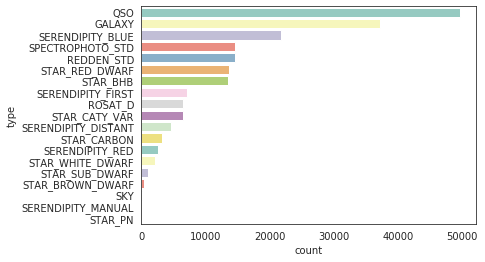

QSO                    49642
GALAXY                 37261
SERENDIPITY_BLUE       21753
SPECTROPHOTO_STD       14629
REDDEN_STD             14613
STAR_RED_DWARF         13745
STAR_BHB               13494
SERENDIPITY_FIRST       7123
ROSAT_D                 6517
STAR_CATY_VAR           6505
SERENDIPITY_DISTANT     4653
STAR_CARBON             3255
SERENDIPITY_RED         2559
STAR_WHITE_DWARF        2160
STAR_SUB_DWARF          1154
STAR_BROWN_DWARF         500
SKY                      127
SERENDIPITY_MANUAL        61
STAR_PN                   13
Name: type, dtype: int64


In [161]:
sns.set_style('white')
sns.countplot(y=train['type'],
              order = train['type'].value_counts().index,
              palette="Set3")
# plt.xticks(rotation='90')
plt.show()

print(train['type'].value_counts())

- 데이터에는 NA가 없음
- 심한 불균형 Class Data
- Train에 심한 이상치가 들어 있어서 왜도를 상당히 심하게 만듬.

# Data Preprocess

In [0]:
col_list = ['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i','psfMag_z', 
            'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i','fiberMag_z', 
            'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i','petroMag_z',
            'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i','modelMag_z']

## 음수 제거

In [147]:
for col in ['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i','psfMag_z', 
            'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i','fiberMag_z', 
            'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i','petroMag_z',
            'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i','modelMag_z']:

            train.drop(train[train[col]<0].index,axis=0,inplace=True)

train.shape

(199775, 23)

In [148]:
train.describe()

,id,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000
mean,99989.916206,360.854451,20.987046,19.860984,19.288714,18.872313,18.612499,21.172838,21.331811,19.505597,19.087514,18.828646,21.612984,19.609804,19.019285,18.609252,18.465849,20.730298,19.530579,18.939891,18.520490,18.276621
std,57735.199457,225.333492,2.247905,1.863039,1.727366,1.628048,1.686594,1.983103,554.988577,1.704242,1.626396,1.677075,392.078346,2.534950,2.735432,1.927741,20.261355,2.185596,1.958846,1.860367,1.796456,1.866562
min,0.000000,1.000000,2.667644,2.741681,11.017885,5.917322,1.762241,2.001454,7.251943,11.795394,10.646672,8.049850,0.333675,0.615563,0.028206,0.189286,0.643462,3.444448,12.498143,11.802798,11.337467,10.977328
25%,49991.500000,174.000000,19.652742,18.701651,18.048764,17.747568,17.425649,19.941607,18.903846,18.259929,17.904648,17.607014,19.249466,18.114730,17.480902,17.051597,16.805719,19.265795,18.075800,17.423288,16.977746,16.705478
50%,99984.000000,349.000000,20.870483,19.903740,19.454268,19.043471,18.610969,21.049216,20.069257,19.632518,19.189932,18.711755,20.367212,19.586342,19.183791,18.694250,18.174592,20.405463,19.546735,19.142977,18.641756,18.100543
75%,149990.500000,526.000000,22.158334,21.148721,20.515141,20.072956,19.883066,22.336923,21.385562,20.774074,20.332017,20.133490,21.796790,21.002898,20.457082,20.018739,19.807081,21.989800,20.960870,20.407302,19.968548,19.819232
max,199990.000000,1000.000000,368.939515,61.356278,117.565177,61.241476,81.345680,105.085577,248077.513380,31.928244,42.002047,40.860707,175257.982891,566.468016,809.628220,122.271336,8647.360709,49.487277,59.987842,35.102312,45.783550,61.597879


In [149]:
test.describe()

,id,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000
mean,204995.000000,359.327805,20.987400,19.878440,19.280218,18.873165,18.618385,21.184506,20.091376,19.497732,19.083329,18.826624,20.715429,19.462021,18.995001,18.616519,18.411996,20.739001,19.534844,18.935095,18.522308,18.281069
std,2889.493756,223.928862,2.111703,2.573890,1.709344,1.720713,1.702236,1.990940,1.865064,1.710070,1.633953,1.711790,2.807434,13.971203,1.979225,1.970463,2.373022,2.187025,1.957506,1.856617,1.796820,1.867582
min,199991.000000,1.000000,-7.248195,-42.663871,9.134712,-22.522266,13.349827,9.390439,8.188752,12.288183,12.688984,-8.455932,-98.181975,-1348.068776,-23.908952,-8.356654,-64.917293,12.419765,13.617577,13.382832,12.955113,12.395695
25%,202493.000000,174.000000,19.655525,18.671025,18.037847,17.742016,17.424701,19.940430,18.892043,18.253627,17.905253,17.610776,19.249432,18.104265,17.475078,17.043615,16.805557,19.268471,18.064625,17.424393,16.971911,16.715685
50%,204995.000000,346.000000,20.854404,19.910333,19.444925,19.033283,18.594713,21.040735,20.071658,19.627904,19.180605,18.699819,20.371014,19.582955,19.197068,18.684269,18.171966,20.412702,19.541261,19.155839,18.635195,18.095883
75%,207497.000000,525.000000,22.160801,21.150040,20.489912,20.083814,19.878652,22.339213,21.402558,20.756306,20.331848,20.119736,21.803705,21.025719,20.428279,20.015701,19.815916,21.992969,20.981396,20.389215,19.970657,19.823902
max,209999.000000,1000.000000,37.681143,182.654452,31.883768,47.227391,34.946057,41.169991,47.160580,29.266687,31.146742,26.478564,65.392087,106.962571,41.850633,52.221528,74.747394,32.641240,28.814977,27.579664,26.471555,24.461973


하지만 몇몇 컬럼의 표준편차는 너무 큰 양수 값 때문에 차이가 많이 나는 것으로 보인다. 좀 더 지워보자.

## 500 이상 데이터 제거

In [150]:
for col in col_list:
  train.drop(train[train[col]>500].index,axis=0,inplace=True)

train.shape

(199764, 23)

## 박스콕스변환
- test 데이터에 음수가 있으므로 우선 생략

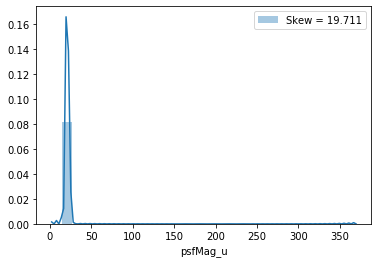

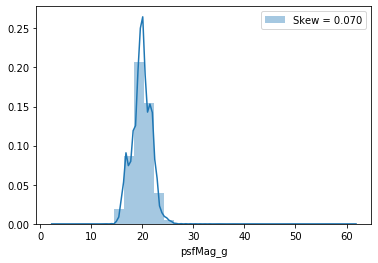

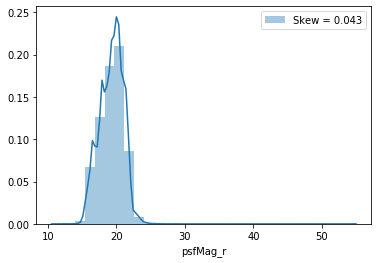

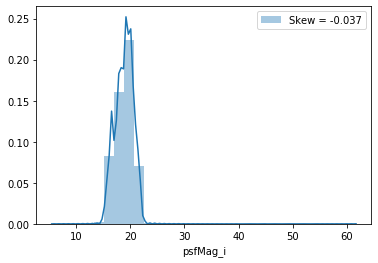

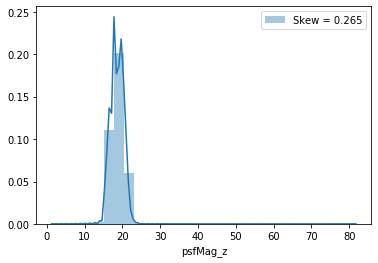

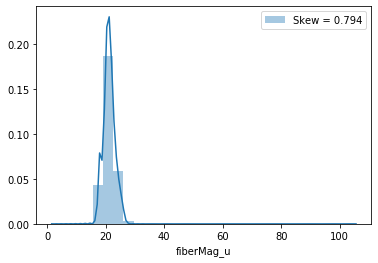

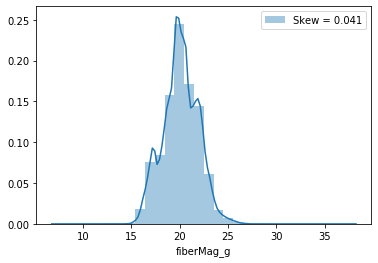

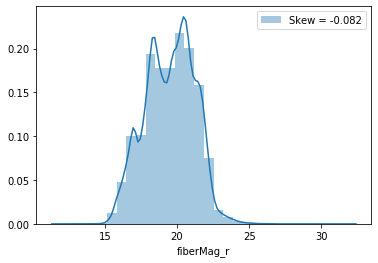

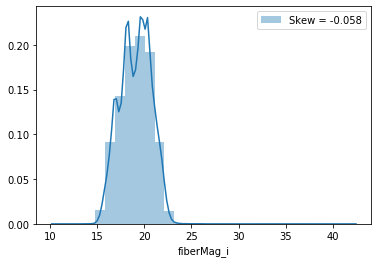

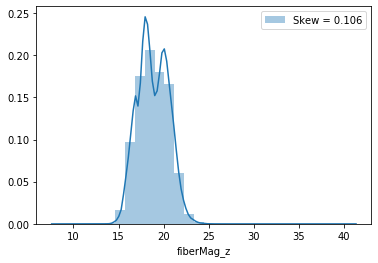

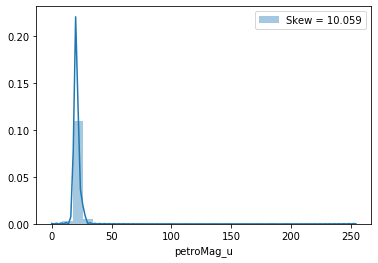

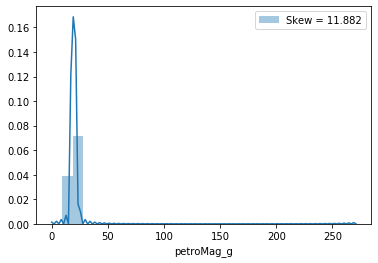

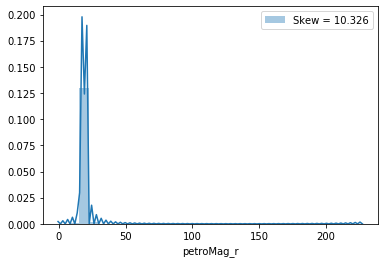

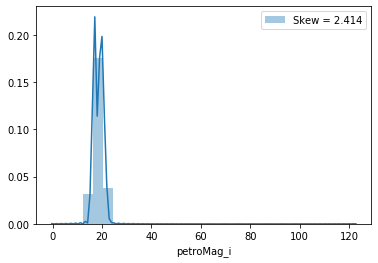

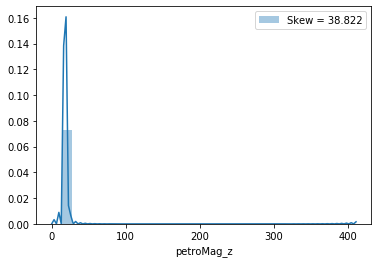

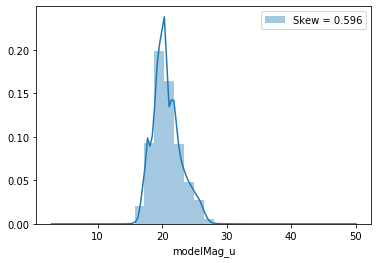

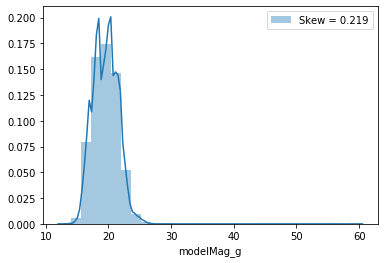

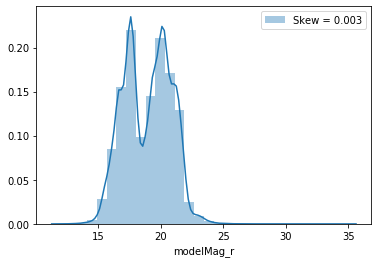

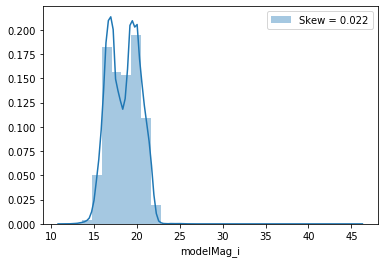

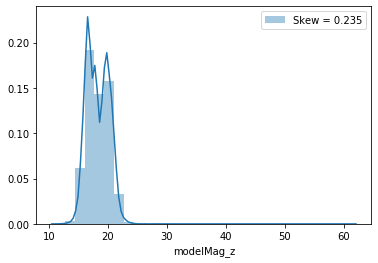

In [151]:
#왜도 확인

for feat in col_list:
    skew = train[feat].skew()
    sns.distplot(train[feat], kde= True, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [0]:
# for col in col_list:
#   # transform training data & save lambda value
#   train[col],fitted_lambda = stats.boxcox(train[col])

#   # use lambda value to transform test data
#   test[col] = stats.boxcox(test[col], fitted_lambda)

#   fig, ax=plt.subplots(1,2)
#   sns.distplot(train[col], ax=ax[0])
#   sns.distplot(test[col], ax=ax[1])

## 파생변수 만들기

In [0]:
k=5
for idx,col in enumerate (col_list):
  for j in range(k):
    train['%s_%s*%s'%(col[:3],
                      col[-1],
                      col_list[idx+j][-1])] = train[col] * train[col_list[idx+j]]
    test['%s_%s*%s'%(col[:3],
                     col[-1],
                     col_list[idx+j][-1])] = test[col] * test[col_list[idx+j]]
  k-=1
  if k==0:
    k=5

In [154]:
train.head()

,id,type,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,psf_u*u,psf_u*g,psf_u*r,psf_u*i,psf_u*z,psf_g*g,psf_g*r,psf_g*i,psf_g*z,psf_r*r,psf_r*i,psf_r*z,psf_i*i,psf_i*z,psf_z*z,fib_u*u,fib_u*g,...,fib_g*g,fib_g*r,fib_g*i,fib_g*z,fib_r*r,fib_r*i,fib_r*z,fib_i*i,fib_i*z,fib_z*z,pet_u*u,pet_u*g,pet_u*r,pet_u*i,pet_u*z,pet_g*g,pet_g*r,pet_g*i,pet_g*z,pet_r*r,pet_r*i,pet_r*z,pet_i*i,pet_i*z,pet_z*z,mod_u*u,mod_u*g,mod_u*r,mod_u*i,mod_u*z,mod_g*g,mod_g*r,mod_g*i,mod_g*z,mod_r*r,mod_r*i,mod_r*z,mod_i*i,mod_i*z,mod_z*z
0,0,QSO,601,23.198224,21.431953,21.314148,21.176553,21.171444,22.581309,21.644453,21.657571,21.387653,21.572827,22.504317,21.431636,21.478312,21.145409,20.422446,22.749241,21.465534,21.364187,21.020605,21.147340,538.157599,497.183257,494.450379,491.258420,491.139907,459.328627,456.803825,453.854896,453.745406,454.292902,451.360182,451.251294,448.446395,448.338210,448.230051,509.915503,488.760078,...,468.482351,468.766278,462.924049,466.932046,469.050377,463.204607,467.215033,457.431693,461.392137,465.386871,506.444301,482.304330,483.354742,475.863003,459.593196,459.315005,460.315348,453.180708,437.686410,461.317870,454.167691,438.639649,447.128336,431.840970,417.076281,517.527987,488.324605,486.019048,478.202816,481.085944,460.769129,458.593671,451.218499,453.938936,456.428485,449.088133,451.795726,441.865830,444.529879,447.209990
1,1,QSO,788,21.431355,20.708104,20.678850,20.703420,20.473229,21.868797,21.029773,20.967054,20.937731,21.063646,21.360701,20.778968,20.889705,20.639812,20.646660,21.492955,20.758527,20.753925,20.693389,20.512314,459.302969,443.802724,443.175775,443.702335,438.769025,428.825571,428.219780,428.728569,423.961746,427.614844,428.122915,423.362826,428.631590,423.865845,419.153088,478.244289,459.895838,...,442.251349,440.932394,440.315722,442.963688,439.617373,439.002540,441.642609,438.388567,441.024943,443.677174,456.279566,443.853330,446.218754,440.880867,441.027134,431.765508,434.066512,428.873996,429.016280,436.379779,431.159591,431.302633,426.001849,426.143180,426.284557,461.947115,446.162082,446.063182,444.762071,440.870245,430.916434,430.820913,429.564262,425.805423,430.725414,429.469041,425.711035,428.216334,424.469289,420.755032
2,2,QSO,427,17.851451,16.727898,16.679677,16.694640,16.641788,18.171890,17.033098,16.999682,17.095999,17.076449,17.867253,16.738784,16.688874,16.744210,16.808006,17.818063,16.697434,16.641249,16.660177,16.688928,318.674315,298.617256,297.756443,298.023551,297.080065,279.822569,279.015935,279.266232,278.382128,278.211626,278.461201,277.579646,278.711001,277.828654,276.949101,330.217592,309.523586,...,290.126428,289.557246,291.197821,290.864827,288.989180,290.626537,290.294197,292.273171,291.938947,291.605106,319.238723,299.076091,298.184338,299.173033,300.312893,280.186900,279.351469,280.277720,281.345587,278.518528,279.442017,280.506701,280.368569,281.436782,282.509066,317.483361,297.515933,296.514813,296.852088,297.364374,278.804313,277.866156,278.182219,278.662286,276.931156,277.246155,277.724607,277.561513,278.040509,278.520332
3,3,QSO,864,20.789900,20.040371,19.926909,19.843840,19.463270,21.039030,20.317165,20.217898,20.073852,19.794505,20.433907,19.993727,19.985531,19.750917,19.455117,20.770711,20.001699,19.889798,19.758113,19.552855,432.219942,416.637309,414.278441,412.551439,404.639444,401.616469,399.342645,397.677906,390.051158,397.081694,395.426380,387.842812,393.777967,386.226013,378.818892,442.640794,427.453447,...,412.787189,410.770364,407.843762,402.168230,408.763394,405.851090,400.203288,402.959535,397.351973,391.822444,417.544547,408.549957,408.382468,403.588397,397.544054,399.749124,399.585244,394.894444,388.980307,399.421431,394.732554,388.820841,390.098721,384.256407,378.501589,431.422441,415.449517,413.125257,410.390056,406.126702,400.067973,397.829765,395.195832,391.090325,395.604

In [155]:
test.head()

,id,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,psf_u*u,psf_u*g,psf_u*r,psf_u*i,psf_u*z,psf_g*g,psf_g*r,psf_g*i,psf_g*z,psf_r*r,psf_r*i,psf_r*z,psf_i*i,psf_i*z,psf_z*z,fib_u*u,fib_u*g,fib_u*r,...,fib_g*g,fib_g*r,fib_g*i,fib_g*z,fib_r*r,fib_r*i,fib_r*z,fib_i*i,fib_i*z,fib_z*z,pet_u*u,pet_u*g,pet_u*r,pet_u*i,pet_u*z,pet_g*g,pet_g*r,pet_g*i,pet_g*z,pet_r*r,pet_r*i,pet_r*z,pet_i*i,pet_i*z,pet_z*z,mod_u*u,mod_u*g,mod_u*r,mod_u*i,mod_u*z,mod_g*g,mod_g*r,mod_g*i,mod_g*z,mod_r*r,mod_r*i,mod_r*z,mod_i*i,mod_i*z,mod_z*z
0,199991,251,23.817399,22.508963,20.981106,18.517316,17.076079,25.053890,23.167848,21.335901,18.835858,17.434384,22.246697,22.796239,21.195315,18.584486,17.154284,25.391534,22.499435,21.011918,18.499341,17.091474,567.268505,536.104949,499.715378,441.034303,406.707793,506.653399,472.262931,416.805569,384.364826,440.206809,388.513766,358.275026,342.890984,316.203149,291.592477,627.697397,580.444724,534.547321,...,536.749203,494.306929,436.386309,403.917170,455.220685,401.880012,371.978300,354.789555,328.391588,303.957751,494.915507,507.141019,471.525741,413.443410,381.626149,519.668529,483.173474,423.656380,391.053162,449.241378,393.904025,363.590451,345.383102,318.803541,294.269456,644.730001,571.295163,533.524827,469.726646,433.978747,506.224562,472.756273,416.224714,384.548506,441.500690,388.706632,359.124649,342.225616,316.181007,292.118487
1,199992,386,22.806983,21.937111,20.335770,20.000512,19.527369,22.498565,22.186000,20.618879,20.301204,20.030078,21.729831,21.837511,20.196128,19.967204,19.683671,22.475338,21.853442,20.173169,19.796757,19.567372,520.158463,500.319304,463.797557,456.151332,445.360369,481.236822,446.108037,438.753443,428.374054,413.543544,406.725812,397.104086,400.020479,390.557378,381.318141,506.185410,499.153157,463.895192,...,492.218601,457.450462,450.402512,444.387313,425.138191,418.588076,412.997764,412.138880,406.634698,401.204025,472.185544,474.525411,438.858453,433.883956,427.722844,476.876872,441.033171,436.034024,429.842380,407.883604,403.260210,397.533952,398.689223,393.027872,387.446912,505.140820,491.163495,453.398803,444.938811,439.783309,477.572925,440.853188,432.627285,427.614436,406.956766,399.363338,394.735919,391.911597,387.370521,382.882062
2,199993,232,21.024250,19.235669,18.304061,17.808608,17.380113,21.205546,19.439533,18.344433,17.909690,17.538164,20.722629,18.710223,17.611851,17.158519,16.843986,20.579314,18.653338,17.562108,17.120529,16.708748,442.019104,404.415520,384.829157,374.412634,365.403845,370.010960,352.090854,342.560489,334.318098,335.038641,325.969844,318.126643,317.146520,309.515618,302.068324,449.675188,412.225914,389.003717,...,377.895444,356.607207,348.156006,340.933720,336.518215,328.543101,321.727673,320.756988,314.103079,307.587200,429.427346,387.725001,364.963860,355.569627,349.051678,350.072435,329.521663,321.039718,315.154738,310.177311,302.193293,296.653786,294.414784,289.017865,283.719878,423.508184,383.872909,361.416145,352.328759,343.854577,347.947020,327.591939,319.355023,311.673922,308.427641,300.672589,293.440837,293.112528,286.062610,279.182256
3,199994,557,20.503424,20.286261,20.197204,20.162419,20.059832,20.976132,20.611498,20.567262,20.479318,20.277472,20.329269,20.385262,20.129157,20.206574,20.212342,20.479879,20.280943,20.150499,20.206221,20.092909,420.390408,415.937808,414.111835,413.398625,411.295241,411.532367,409.725735,409.020079,406.938972,407.927033,407.224475,405.152505,406.523127,404.454725,402.396848,439.998110,432.349507,431.421595,...,424.833862,423.922080,422.109424,417.949077,423.012254,421.203489,417.052071,419.402458,415.268791,411.175867,413.279184,414.417476,409.211043,410.784888,410.902151,415.558902,410.338129,411.916309,412.033895,405.182946,406.741299,406.857407,408.305645,408.422200,408.538789,419.425457,415.351259,412.679795,413.820959,411.500358,

## 정규화

In [156]:
train.columns

Index(['id', 'type', 'fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i',
       'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i',
       'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z', 'psf_u*u', 'psf_u*g', 'psf_u*r', 'psf_u*i', 'psf_u*z',
       'psf_g*g', 'psf_g*r', 'psf_g*i', 'psf_g*z', 'psf_r*r', 'psf_r*i',
       'psf_r*z', 'psf_i*i', 'psf_i*z', 'psf_z*z', 'fib_u*u', 'fib_u*g',
       'fib_u*r', 'fib_u*i', 'fib_u*z', 'fib_g*g', 'fib_g*r', 'fib_g*i',
       'fib_g*z', 'fib_r*r', 'fib_r*i', 'fib_r*z', 'fib_i*i', 'fib_i*z',
       'fib_z*z', 'pet_u*u', 'pet_u*g', 'pet_u*r', 'pet_u*i', 'pet_u*z',
       'pet_g*g', 'pet_g*r', 'pet_g*i', 'pet_g*z', 'pet_r*r', 'pet_r*i',
       'pet_r*z', 'pet_i*i', 'pet_i*z', 'pet_z*z', 'mod_u*u', 'mod_u*g',
       'mod_u*r', 'mod_u*i', 'mod_u*z', 'mod_g*g', 'mod_g*r', 'mod_g*i',
       'mod_g*z', 'mod_r*r', 'm

In [0]:
col_list=['fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i',
       'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i',
       'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z', 'psf_u*u', 'psf_u*g', 'psf_u*r', 'psf_u*i', 'psf_u*z',
       'psf_g*g', 'psf_g*r', 'psf_g*i', 'psf_g*z', 'psf_r*r', 'psf_r*i',
       'psf_r*z', 'psf_i*i', 'psf_i*z', 'psf_z*z', 'fib_u*u', 'fib_u*g',
       'fib_u*r', 'fib_u*i', 'fib_u*z', 'fib_g*g', 'fib_g*r', 'fib_g*i',
       'fib_g*z', 'fib_r*r', 'fib_r*i', 'fib_r*z', 'fib_i*i', 'fib_i*z',
       'fib_z*z', 'pet_u*u', 'pet_u*g', 'pet_u*r', 'pet_u*i', 'pet_u*z',
       'pet_g*g', 'pet_g*r', 'pet_g*i', 'pet_g*z', 'pet_r*r', 'pet_r*i',
       'pet_r*z', 'pet_i*i', 'pet_i*z', 'pet_z*z', 'mod_u*u', 'mod_u*g',
       'mod_u*r', 'mod_u*i', 'mod_u*z', 'mod_g*g', 'mod_g*r', 'mod_g*i',
       'mod_g*z', 'mod_r*r', 'mod_r*i', 'mod_r*z', 'mod_i*i', 'mod_i*z',
       'mod_z*z']

In [0]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
for data in [train,test]:
  stdsc.fit(data[col_list])
  data[col_list]=stdsc.transform(data[col_list])

## 데이터 분리

# RandomForest 변수 추출

# 모델링

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline

LR = LogisticRegression(solver='liblinear',#,'lbfgs'
                        max_iter=10000,
                       penalty='l2',
                       C=10,
                       random_state=3,
                       multi_class='auto')
DT = DecisionTreeClassifier(max_depth=3,
                           criterion='entropy',
                           random_state=3)
KN = KNeighborsClassifier(n_neighbors=4,
                         p=2,
                         metric='minkowski')
SV = SVC(gamma='auto',
        probability=True)

Hardvoting = VotingClassifier(estimators=[('LogisticRegression', LR),
                                           ('DecisionTree', DT),
                                          ('KNeighbors', KN),
                                         ('SVM', SV)],
                                voting='hard')

Softvoting = VotingClassifier(estimators=[('LogisticRegression', LR),
                                           ('DecisionTree', DT),
                                          ('KNeighbors', KN),
                                         ('SVM', SV)],
                                voting='soft')

RF = RandomForestClassifier(n_estimators=100)
#Bagging Clssifier - Redundancy available
#Pasting - No Redundancy


Bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 100,
                           max_samples = 300, bootstrap = True, #True->Bagging
                           n_jobs = -1 # -1 means use all cpu cores available
                           )
Paste_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 100,
                           max_samples = 300, bootstrap = False, #True->Bagging
                           n_jobs = -1 # -1 means use all cpu cores available
                           )

AdaBoost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=100,
                              algorithm="SAMME.R", learning_rate=0.5)
GradientBoost = GradientBoostingClassifier(max_depth=3, n_estimators=100,
                                          learning_rate=0.5)
print('----Validation score----')
for clf_name, clf in zip(['LogisticRegression', 'DecisionTree', 'KNeighbors', 'SVM', 'HardVoting', 'Softvoting','RandomForest', 'Bagging', 'Pasting', 'AdaBoost', 'GradientBoost'],[LR, DT, KN, SV, Hardvoting, Softvoting, RF, Bag_clf, Paste_clf, AdaBoost, GradientBoost]):
    scores = cross_val_score(estimator= clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring='accuracy')
    print("ACCURACY : %f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), clf_name))